<a href="https://colab.research.google.com/github/DebeckGZN/BlackJack/blob/master/GEOFUSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Leitura dos Dados

Faremos a separação entre as bases de RJ e SP


In [1]:
import pandas as pd
import numpy as np


filename = "DadosDesafioCientista.xlsx"
df = pd.read_excel(filename)

## headers
headers = list(df)

##separacao por cidade

dados_RJ = df[df['estado'] == 'RJ']

dados_SP = df[df['estado'] == 'SP']

dimensao_original = len(dados_RJ)

##remocao de linhas em branco
dados_RJ = dados_RJ.dropna()

dados_SP = dados_SP.drop(dados_SP[dados_SP.rendaMedia == "-" ].index)

dimensao_pos_filtro = len(dados_RJ)

print("Original: ", dimensao_original, " // Pós Filtro: ", dimensao_pos_filtro)

Original:  160  // Pós Filtro:  154


#Separando  e Agrupando as Colunas de Interesse

In [3]:
cidades = list(dados_RJ['nome'])

populacao = list(dados_RJ["população"])

faturamento = list(dados_RJ['faturamento'])

potencial = list(dados_RJ['potencial'])

idade_alvo = list(dados_RJ['popDe25a34']+dados_RJ['popDe35a49'])

classes_total = list(dados_RJ['domiciliosA1']+dados_RJ['domiciliosA2']
                   +dados_RJ['domiciliosB1']+dados_RJ['domiciliosB2']
                   +dados_RJ['domiciliosC1']+dados_RJ['domiciliosC2']+
                   dados_RJ['domiciliosD']+dados_RJ['domiciliosE'])

classes_alvo = list(dados_RJ['domiciliosA1']+dados_RJ['domiciliosA2']
                   +dados_RJ['domiciliosB1']+dados_RJ['domiciliosB2'])

renda = list(dados_RJ['rendaMedia'])

# Identificando Correlações entre os dados

* População na faixa de idade alvo (25-50)

* População pertencente a classe alvo (A1, A2, B1, B2)

###Hipóteses

Faturamento está relacionado com a Renda Média

Potencial está relacionado com a qtd de domicílios pertencente a classe alvo

#Comparando Faturamento x Classe

Ordenando os valores por Faturamento (Decrescente)



In [4]:
faturamento_ordenado, cidades_ordenado_faturamento = zip(*sorted(zip(faturamento, cidades)))

Ordenando os valores por Classe (Decrescente)


In [5]:
qtd_classe_ordenado, cidades_ordenado_classe_qtd = zip(*sorted(zip(classes_alvo, cidades)))

Ordenando Classe baseado no faturamento

In [6]:
renda_ordem_faturamento = []

for cidade in cidades_ordenado_faturamento:
  idx = cidades.index(cidade)
  renda_equivalente = renda[idx]
  renda_ordem_faturamento.append(renda_equivalente)

Visualizando:

In [7]:
import matplotlib.pyplot as plt

#Faturamento x Renda RJ

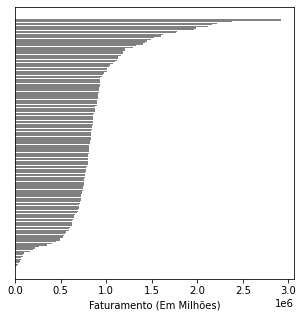

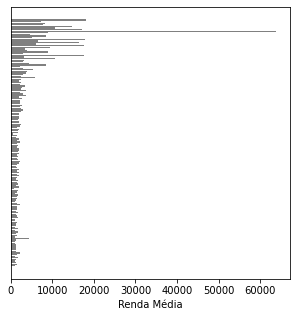

In [8]:
x1points = cidades_ordenado_faturamento
y1points = faturamento_ordenado

f, ax = plt.subplots(1,  figsize=(5,5))
barlist = plt.barh(x1points, y1points, color = 'gray')

ax.get_yaxis().set_visible(False)
plt.xlabel('Faturamento (Em Milhões)')
plt.show()

x2points = cidades_ordenado_faturamento
y2points = renda_ordem_faturamento

f, ax = plt.subplots(1, figsize=(5,5))
barlist = plt.barh(x2points, y2points, color = 'gray')

ax.get_yaxis().set_visible(False)
plt.xlabel('Renda Média')
    
plt.show()

# Classe alvo x Potencial RJ

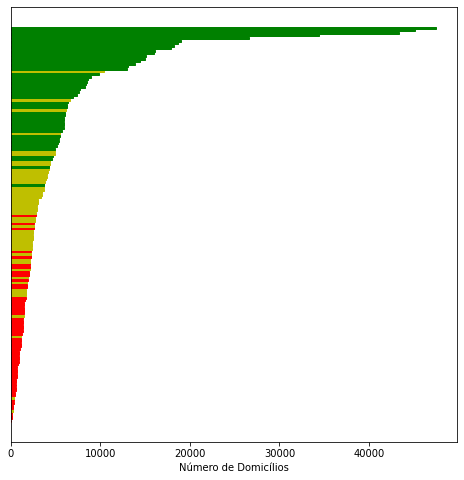

In [9]:
x3points = cidades_ordenado_classe_qtd
y3points = qtd_classe_ordenado

f, ax = plt.subplots(1,  figsize=(8,8))
barlist = plt.barh(x3points, y3points, color = 'gray')
ax.get_yaxis().set_visible(False)

plt.xlabel('Número de Domicílios')
for cidade in x3points:
  potencial_idx = cidades.index(cidade)
  potencial_cidade = potencial[potencial_idx]
  idx = x3points.index(cidade)
  if potencial_cidade == 'Alto':
    barlist[idx].set_color('g')
  if potencial_cidade == 'Médio':
    barlist[idx].set_color('y')
  if potencial_cidade == 'Baixo':
    barlist[idx].set_color('r')
plt.show()

#Estimando o Faturamento (Regressão Linear)

In [10]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

d = {"populacao":populacao,"popIdadeAlvo": idade_alvo,"classeAlvo":classes_alvo, "renda": renda }
X = pd.DataFrame(d)
Y = faturamento
X.tail()


,populacao,popIdadeAlvo,classeAlvo,renda
149,18791.0,6444.0,2396.0,2316.0
150,13556.0,5450.0,1761.0,2416.0
151,33190.0,11935.0,6013.0,3189.0
152,8867.0,3017.0,1479.0,2418.0
153,2072.0,735.0,500.0,3791.0


In [23]:
from sklearn.model_selection import train_test_split

train_dataset, test_dataset, train_labels, test_labels = train_test_split(X,Y, test_size=0.3)

In [24]:
train_statsReg = train_dataset.describe()
train_statsReg = train_statsReg.transpose()
train_statsReg

,count,mean,std,min,25%,50%,75%,max
populacao,107.0,44102.654206,73096.313678,173.0,13996.0,25549.0,45890.0,667603.0
popIdadeAlvo,107.0,15803.074766,22827.619826,66.0,5358.0,9524.0,16837.0,191432.0
classeAlvo,107.0,5496.392523,8127.509506,0.0,1323.0,2572.0,5819.5,47468.0
renda,107.0,3663.663551,6747.293452,654.0,1517.0,1943.0,2957.5,63887.0


Normalização dos Dados

In [25]:
def norm(x, stats):
  return (x - stats['mean']) / stats['std']
  
normed_train_data = norm(train_dataset,train_statsReg)
normed_test_data = norm(test_dataset,train_statsReg)


Definindo o Modelo

In [26]:
def build_modelRegression():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.01)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae'])
  return model

In [27]:
modelRegression = build_modelRegression()
modelRegression.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 64)                320       
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 dense_8 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


Adaptando os dados para formato adequado (Especificações do Tensorflow)

In [28]:
normed_train_data = np.asarray(normed_train_data).astype('float32')
normed_test_data = np.asarray(normed_test_data).astype('float32')
train_labels = np.asarray(train_labels).astype('float32')
test_labels = np.asarray(test_labels).astype('float32')


Treinamento

In [29]:
EPOCHS = 500
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)
history = modelRegression.fit(
  normed_train_data, train_labels,
  batch_size = 10,
  epochs=EPOCHS, validation_data=(normed_test_data, test_labels), verbose=1, callbacks = [early_stop])

Epoch 1/500
11/11 [==============================] - 1s 19ms/step - loss: 993103249408.0000 - mae: 884263.6875 - val_loss: 858805043200.0000 - val_mae: 837988.1875
Epoch 2/500
11/11 [==============================] - 0s 5ms/step - loss: 992846217216.0000 - mae: 884119.5625 - val_loss: 858463010816.0000 - val_mae: 837793.6250
Epoch 3/500
11/11 [==============================] - 0s 6ms/step - loss: 992313147392.0000 - mae: 883833.5000 - val_loss: 857836355584.0000 - val_mae: 837437.1250
Epoch 4/500
11/11 [==============================] - 0s 5ms/step - loss: 991457574912.0000 - mae: 883349.3750 - val_loss: 856897486848.0000 - val_mae: 836907.0625
Epoch 5/500
11/11 [==============================] - 0s 7ms/step - loss: 990243323904.0000 - mae: 882676.1875 - val_loss: 855648894976.0000 - val_mae: 836199.8125
Epoch 6/500
11/11 [==============================] - 0s 5ms/step - loss: 988662661120.0000 - mae: 881800.1250 - val_loss: 854006235136.0000 - val_mae: 835273.1875
Epoch 7/500
11/11 [==

Métricas de Treinamento

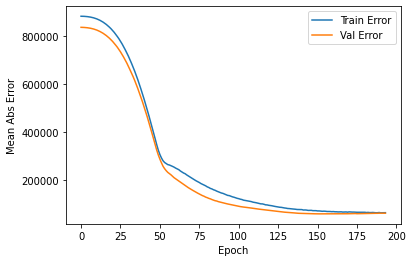

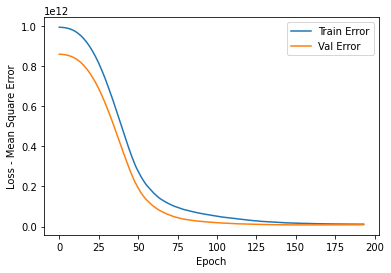

In [30]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Loss - Mean Square Error')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.legend()
  plt.show()


plot_history(history)

In [31]:
loss, mae = modelRegression.evaluate(normed_test_data, test_labels, verbose=2)
faturamento_medio = np.mean(faturamento)
print("Testing set Mean Abs Error: {:5.2f}".format(mae))
print("Faturamento Médio:",faturamento_medio)

2/2 - 0s - loss: 8056347648.0000 - mae: 58717.1641 - 21ms/epoch - 11ms/step
Testing set Mean Abs Error: 58717.16
Faturamento Médio: 870180.3311688312


Visualizando as Predições (em cima da base de Teste)

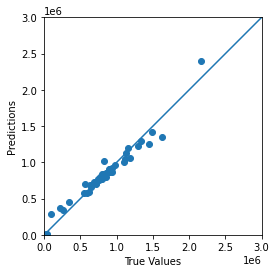

In [32]:
faturamento_predictions = modelRegression.predict(normed_test_data).flatten()

max = 3000000

plt.scatter(test_labels, faturamento_predictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,max])
plt.ylim([0,max])
_ = plt.plot([0, max], [0, max])

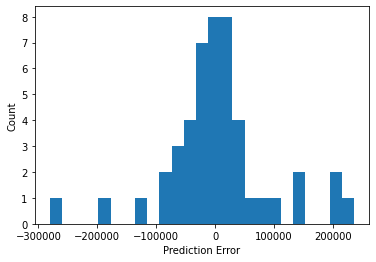

In [33]:
error = faturamento_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

##Classicando Potencial (Classificação Multi Classe)

In [34]:
d = {"populacao":populacao,"popIdadeAlvo": idade_alvo,"classeAlvo":classes_alvo, "renda": renda }
X = pd.DataFrame(d)
Y = potencial
X.tail()

,populacao,popIdadeAlvo,classeAlvo,renda
149,18791.0,6444.0,2396.0,2316.0
150,13556.0,5450.0,1761.0,2416.0
151,33190.0,11935.0,6013.0,3189.0
152,8867.0,3017.0,1479.0,2418.0
153,2072.0,735.0,500.0,3791.0


Transformando Labels em arrays binários (Necessário para problemas multi classe)

[1. 0. 0.] - Alto

[0. 1. 0.] - Baixo

[0. 0. 1.] - Médio

In [35]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils


encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

dummy_y = np_utils.to_categorical(encoded_Y)

In [36]:
train_dataset, test_dataset, train_labels, test_labels = train_test_split(X,dummy_y, test_size=0.3)

In [37]:
train_statsClass = train_dataset.describe()
train_statsClass = train_statsClass.transpose()
train_statsClass

,count,mean,std,min,25%,50%,75%,max
populacao,107.0,47283.635514,74744.985046,173.0,13147.5,27411.0,47908.5,667603.0
popIdadeAlvo,107.0,16996.560748,23527.599888,66.0,5045.0,10053.0,17342.5,191432.0
classeAlvo,107.0,5981.654206,8790.354669,0.0,1385.5,2870.0,6091.0,47468.0
renda,107.0,3939.663551,6928.316013,654.0,1519.5,1944.0,3229.5,63887.0


In [38]:
normed_train_data = norm(train_dataset,train_statsClass)
normed_test_data = norm(test_dataset,train_statsClass)

In [39]:
def build_modelClassification():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax')
  ])

  model.compile(loss='categorical_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'])
  return model

In [40]:
modelClassification = build_modelClassification()
modelClassification.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 64)                320       
                                                                 
 dense_10 (Dense)            (None, 64)                4160      
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 4,675
Trainable params: 4,675
Non-trainable params: 0
_________________________________________________________________


In [41]:
tf_train_dataset = np.asarray(normed_train_data).astype('float32')
tf_test_dataset = np.asarray(normed_test_data).astype('float32')
tf_train_labels = np.asarray(train_labels).astype('float32')
tf_test_labels = np.asarray(test_labels).astype('float32')

In [42]:
EPOCHS = 200

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)

history = modelClassification.fit(
  normed_train_data, train_labels,
  batch_size = 16,
  epochs=EPOCHS, validation_data=(tf_test_dataset, tf_test_labels), verbose=1, callbacks=[early_stop])

Epoch 1/200
7/7 [==============================] - 1s 38ms/step - loss: 1.0610 - accuracy: 0.3645 - val_loss: 1.0633 - val_accuracy: 0.5532
Epoch 2/200
7/7 [==============================] - 0s 7ms/step - loss: 0.9638 - accuracy: 0.5514 - val_loss: 0.9948 - val_accuracy: 0.5957
Epoch 3/200
7/7 [==============================] - 0s 10ms/step - loss: 0.9037 - accuracy: 0.5794 - val_loss: 0.9422 - val_accuracy: 0.6170
Epoch 4/200
7/7 [==============================] - 0s 6ms/step - loss: 0.8532 - accuracy: 0.5981 - val_loss: 0.9004 - val_accuracy: 0.6170
Epoch 5/200
7/7 [==============================] - 0s 9ms/step - loss: 0.8098 - accuracy: 0.6262 - val_loss: 0.8643 - val_accuracy: 0.6383
Epoch 6/200
7/7 [==============================] - 0s 9ms/step - loss: 0.7736 - accuracy: 0.6262 - val_loss: 0.8366 - val_accuracy: 0.6809
Epoch 7/200
7/7 [==============================] - 0s 9ms/step - loss: 0.7425 - accuracy: 0.6449 - val_loss: 0.8079 - val_accuracy: 0.6809
Epoch 8/200
7/7 [========

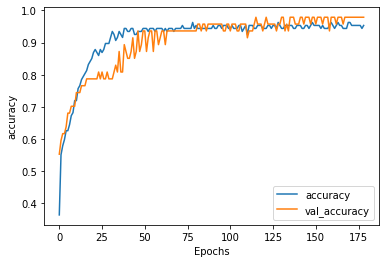

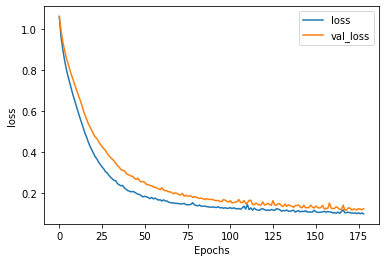

In [43]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [44]:
potencial_predictions = modelClassification.predict(tf_test_dataset)

results = []
real = []
for i in potencial_predictions:
  pred = list(i)
  max_value = np.max([i[0],i[1],i[2]])
  idx = pred.index(max_value)
  if idx == 0: 
    results.append("Alto")
  elif idx == 1:
    results.append("Baixo")
  else:
    results.append("Médio")

for i in test_labels:
  if i[0] == 1:
    real.append("Alto")
  elif i[1] == 1:
    real.append("Baixo")
  else:
    real.append("Médio")

desc = {"Real": real,"Predição": results}
predict_table = pd.DataFrame(desc)
predict_table

,Real,Predição
0,Alto,Alto
1,Baixo,Baixo
2,Médio,Médio
3,Médio,Médio
4,Baixo,Baixo
5,Baixo,Baixo
6,Baixo,Baixo
7,Alto,Alto
8,Baixo,Baixo
9,Médio,Médio


#Prevendo Resultados em SP

In [45]:
populacaoSP = list(dados_SP["população"])

idade_alvoSP = list(dados_SP['popDe25a34']+dados_SP['popDe35a49'])

classes_alvoSP = list(dados_SP['domiciliosA1']+dados_SP['domiciliosA2']
                   +dados_SP['domiciliosB1']+dados_SP['domiciliosB2'])

rendaSP = list(dados_SP['rendaMedia'])

In [46]:
SP_dict = {"populacao":populacaoSP,"popIdadeAlvo": idade_alvoSP,"classeAlvo":classes_alvoSP, "renda": rendaSP }

SP_data = pd.DataFrame(SP_dict)

SP_stats = SP_data.describe()
SP_stats = SP_stats.transpose()

norm_SP_data = norm(SP_data, SP_stats)


In [47]:

faturamento_predictions_SP = modelRegression.predict(norm_SP_data).flatten()
potencial_predictions_SP = modelClassification.predict(norm_SP_data)

results_potencial_SP = []
for i in potencial_predictions_SP:
  pred = list(i)
  max_value = np.max([i[0],i[1],i[2]])
  idx = pred.index(max_value)
  if idx == 0: 
    results_potencial_SP.append("Alto")
  elif idx == 1:
    results_potencial_SP.append("Baixo")
  else:
    results_potencial_SP.append("Médio")


dados_SP["faturamento"] = faturamento_predictions_SP.astype(int)
dados_SP["potencial"] = results_potencial_SP

dados_SP.to_csv("Predicao_SP.csv")

# Comparando RJ x SP

In [48]:
vizSP = pd.read_csv("Predicao_SP.csv", usecols = ['nome','faturamento','potencial','rendaMedia'])

cidadesSP = list(vizSP['nome'])

faturamentoSP = list(vizSP["faturamento"])

potencialSP = list(vizSP["potencial"])

rendaSP = list(vizSP["rendaMedia"])

faturamento_ordenadoSP, cidades_ordenado_faturamentoSP = zip(*sorted(zip(faturamentoSP, cidadesSP)))

classe_ordenadoSP, cidades_ordenado_classeSP = zip(*sorted(zip(classes_alvoSP, cidadesSP)))

renda_ordem_faturamentoSP = []

for cidade in cidades_ordenado_faturamentoSP:
  idx = cidadesSP.index(cidade)
  renda_equivalente = rendaSP[idx]
  renda_ordem_faturamentoSP.append(renda_equivalente)

# Faturamento x Renda SP


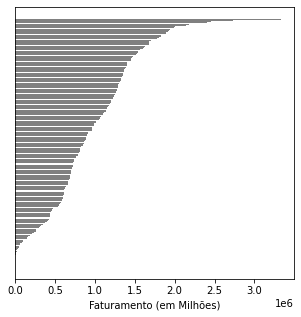

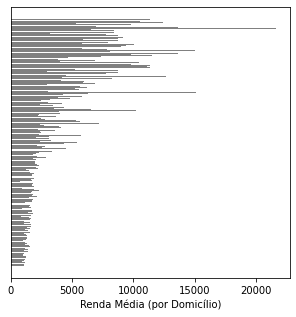

In [52]:
x1_points = cidades_ordenado_faturamentoSP
y1_points = faturamento_ordenadoSP

f, ax = plt.subplots(1,  figsize=(5,5))
barlist = plt.barh(x1_points, y1_points, color = 'gray')

ax.get_yaxis().set_visible(False)
plt.xlabel('Faturamento (em Milhões)')
plt.show()

x2_points = cidades_ordenado_faturamentoSP
y2_points = renda_ordem_faturamentoSP

f, ax = plt.subplots(1, figsize=(5,5))
barlist = plt.barh(x2_points, y2_points, color = 'gray')

ax.get_yaxis().set_visible(False)
plt.xlabel('Renda Média (por Domicílio)')
    
plt.show()

#Classe Alvo x Potencial SP

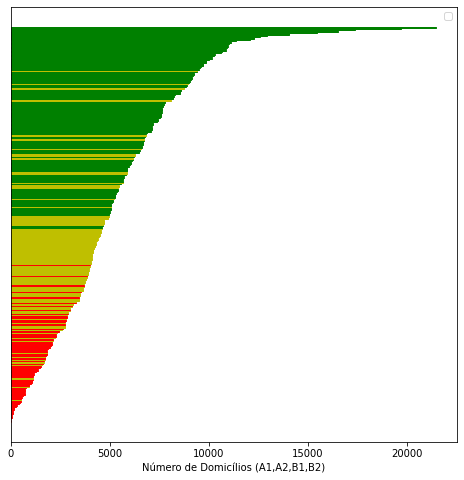

In [53]:
x3_points = cidades_ordenado_classeSP
y3_points = classe_ordenadoSP

f, ax = plt.subplots(1,  figsize=(8,8))
barlist = plt.barh(x3_points, y3_points, color = 'gray')

ax.get_yaxis().set_visible(False)
plt.xlabel('Número de Domicílios (A1,A2,B1,B2)')
for cidade in x3_points:
  potencial_idx = cidadesSP.index(cidade)
  potencial_cidade = potencialSP[potencial_idx]
  idx = x3_points.index(cidade)
  if potencial_cidade == 'Alto':
    barlist[idx].set_color('g')
  if potencial_cidade == 'Médio':
    barlist[idx].set_color('y')
  if potencial_cidade == 'Baixo':
    barlist[idx].set_color('r')
plt.legend()
plt.show()